# Infrastructure in the North Sea

## Goal

The goal of this notebook is to create statistics on the infrastructure in the North Sea. These statistics could be used for leads and to answer questions like:

1. What infrastructure is present in the North Sea?
2. Who owns this infrastructure?
3. What has been removed? And what obsolete infrastructure has remained? 
4. Where is this infrastructure located?
5. How can this infrastructure be re-used?
6. What spatial conflicts arise because this infrastructure is present?

## Data

We are using public data provided by the relevant national and European agencies:
1. [EMODnet](https://www.emodnet-humanactivities.eu/view-data.php) (European Commission)
2. [North Sea Transition Authority](https://www.nstauthority.co.uk/) (UK)
3. [NLOG](https://nlog.nl) (Netherlands)
4. [Oljedirektoratet, NPD](https://npd.no/) (NO)

We are still missing good data sources from Germany and Denmark, for they don't seem to have convenient data portals like Norway, the Netherlands and the UK. 

The EMODnet data is aggregated from national sources and validated. That means the data are realiable, but also not as current and elaborate as data from national sources. Maybe it will turn out that the EMODnet data is fit for purpose, but to be sure, I'll include analyses of national sources. 

## Process

This elaborate notebook is used to import the raw data from a PostgreSQL instance, clean and transform the data where necessary, perform basic statistics and describe the outcomes. This notebook can therefore be used to get a first sense of what infrastructure is out there at sea, who owns it and other relevant information for leads. 

```{caution}
Please keep in mind that all data, even from trusted national sources is messy. Where possible I will provide caveats and warnings, but if information is being used for a story, please doublecheck.
```

Infrastructure that will be part of this investigation is basically everything man-made like:
- Fossil fuel infrastructure (platforms, manifolds, riser bases, fpsos, concrete mattresses, etc)
- Fossil fuel pipelines
- Communication and electricity cables
- Wind energy and other renewables infrastructure

```{caution}
This notebook will focus on infrastructure in general. Pipelines, communication and electricity cables and renewables infrastructure will be the focus of other notebooks
```

```{tip}
You can find a **lexicon** of all infrastructure types [at our wiki](https://wiki.ftm.nl/NorthSea/Infrastructure/lexicon). And all information will be made searchable (also spatially) in [this ArcGIS dashboard](https://ftm.maps.arcgis.com). You need to permission to access these resources.
```

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import plotly.express as px
import datetime as dt
from sqlalchemy import create_engine
from sqlalchemy import text
import psycopg2
from dotenv import load_dotenv
import os

load_dotenv('.env')

# Load environment variables
PATH_RAW = os.environ.get('PATH_RAW')
POSTGRES = os.environ.get('POSTGRES_DB')

### Platforms (EMODnet)

The dataset on offshore installations for Oil and Gas exploitation and exploration activities was created in 2015 by Cogea for the European Marine Observation and Data Network (EMODnet). It is the result of the aggregation and harmonization of datasets provided by several EU and non-EU sources. It is updated every year, and is available for viewing and download on EMODnet Human Activities [web portal](www.emodnet-humanactivities.eu). Metadata cound be found [here](https://www.emodnet-humanactivities.eu/search-results.php?dataname=Offshore+Installations#ID0EABA)

In [2]:
def create_dataframes(tables, crs=None):
    
    '''Takes a list of table names in PostgreSQL
    and returns a dataframe'''
    
    d = {}

    for name in tables:
        d[name] = gpd.read_postgis(text(f'SELECT * FROM {name}'), 
                                        connection, 
                                        geom_col='geometry')
        
        if crs:
            d[name] = d[name].set_crs(crs, allow_override=True)

    # Create df name and assign dfs from dict

    for table in tables:
        globals()[table] = d[table]
        print(f'Created dataframe {table} with {len(globals()[table])} rows')

In [3]:
# Instantiate connection
engine = create_engine(POSTGRES)
connection = engine.connect()

In [4]:
tables = ['int_platforms']

create_dataframes(tables)

Created dataframe int_platforms with 1435 rows


In [5]:
int_platforms.head()

id  country platformid current_status     name     category  \
0  platforms.21  Denmark       DK35    Operational  Tyra WC  Fixed steel   
1  platforms.22  Denmark       DK32    Operational  Tyra EF  Fixed steel   
2  platforms.23  Denmark       DK14    Operational   Gorm B  Fixed steel   
3  platforms.24  Denmark       DK17    Operational   Gorm E  Fixed steel   
4  platforms.25  Denmark       DK13    Operational   Gorm A  Fixed steel   

                 function operator location_blocks primary_production  \
0  Above water production    Mærsk         5504/11        Natural Gas   
1  Above water production    Mærsk         5504/12        Natural Gas   
2  Above water production    Mærsk         5504/16          Crude Oil   
3  Above water production    Mærsk         5504/16          Crude Oil   
4  Above water production    Mærsk         5504/16          Crude Oil   

   weight_sub  weight_top production_start valid_to  water_depth  \
0      1499.0       815.0       01/01/1984     None         41.0   
1       700.0      3100.0       01/01/1995     None         37.0   
2      1080.0       945.0       01/01/1981     None         38.0   
3      1634.0      3900.0       01/01/1981     None         38.0   
4      1080.0      1100.0       01/01/1981     None         38.0   

      coast_dist                         remarks                  geometry  
0  210002.399704                        Wellhead  POINT (4.74883 55.71546)  
1  206740.728192       Bridge module, processing  POINT (4.80149 55.72187)  
2  209016.128718                        Wellhead  POINT (4.75903 55.57920)  
3  208872.107172  Riser. Owner: DONG OIL PIPE AS  POINT (4.76126 55.58142)  
4  209000.693624                        Wellhead  POINT (4.75926 55.57978)

### UK fossil fuel infrastructure (excluding pipelines)

In [6]:
# Select tables

tables = ['uk_subsea_points',
          'uk_subsea_points_removed',
          'uk_surface_points',
          'uk_surface_points_removed',
          'uk_subsea_linear',
          'uk_subsea_linear_removed']

create_dataframes(tables, '4230')

Created dataframe uk_subsea_points with 24328 rows
Created dataframe uk_subsea_points_removed with 10635 rows
Created dataframe uk_surface_points with 704 rows
Created dataframe uk_surface_points_removed with 12114 rows
Created dataframe uk_subsea_linear with 1893 rows
Created dataframe uk_subsea_linear_removed with 3190 rows


### Netherlands 

In [7]:
tables = ['nl_facility']

create_dataframes(tables)

Created dataframe nl_facility with 1266 rows


### Norway

In [8]:
tables = ['no_facility',
          'no_facility_function']

create_dataframes(tables)

Created dataframe no_facility with 1124 rows
Created dataframe no_facility_function with 1254 rows


### Import company data

```{caution}
In some datasets only a representative is named. Sometimes that is an operator, sometimes a license holder, and sometimes the company that actually performed the work, for instance a subcontractor. Even within the same datasets, different approaches have been used. If you use this information, please check it. 
```

I've also added normalised names, because the same companies often emerge with many different names (e.g. AKER ASA, AKER AS, AKER ENERGY). I've tried to normalise every name to a local name (in the previous example AKER ENERGY), but also to an international name. Many companies have been acquired or have merged through the decades by international operating companies. The international name is the name as of December 1st 2022. This re-naming is manual work (a lot of Googling and combing through company registries) and that process is prone to errors. Please be careful with this data. If you see any mistakes, please let me know, because it's trivial to change the data and perform the analyses anew if necessary. 

In [9]:
# Import company data

com = pd.read_excel(f'../data/companies_clean_current.xlsx',
                   sheet_name='local')

print(f'Found {com.name_db.nunique()} unique companies ({com.name_international.nunique()} after cleaning)')

Found 1370 unique companies (647 after cleaning)


## Explore data EMODnet

In [10]:
# Create subset of data of relevant countries

selection = ['Denmark', 'Belgium', 'Germany', 'United Kingdom', 'Netherlands', 'Norway']
emod = int_platforms[int_platforms.country.isin(selection)]
emod[['category', 'operator']] = emod[['category', 'operator']].apply(lambda x: x.str.upper())
print(f'Found {len(emod)} items out of {len(int_platforms)} in total')

Found 1435 items out of 1435 in total


In [11]:
# Merge with clean company data

emod = pd.merge(emod, 
                com[['name_db', 'name_international']], 
                left_on='operator', 
                right_on='name_db',
                how='left')

emod = emod.rename(columns={'name_international': 'name_normalised'})

print(f'Found {emod.name_normalised.isna().sum()} rows that could not be merged')

Found 83 rows that could not be merged


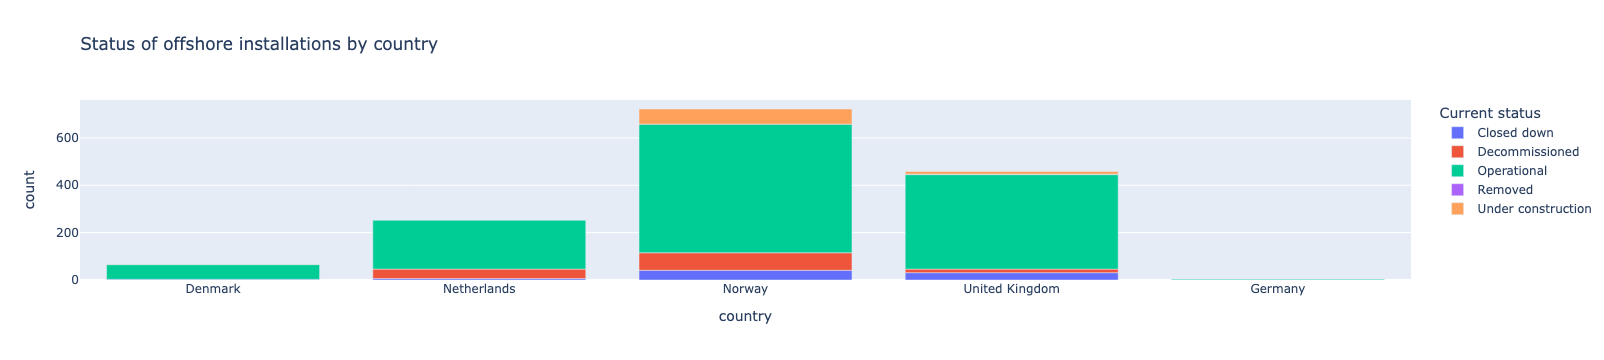

In [12]:
# Visualise status by country

status = emod.groupby(['current_status', 'country'])['id'].count().reset_index(name='count')

fig = px.bar(status, 
             x='country', 
             y='count',
             labels=({'x': 'Country',
                      'y': 'Number of offshore installations',
                      'current_status': 'Current status'}),
             color='current_status', 
             title='Status of offshore installations by country')

fig.show()

```{tip}
These charts are interactive. You can select filter by clicking the legend, zoom in and select. 
```

Norway has - by far, the most offshore installations, which isn't very surprising. What is striking though, is the number of decommissioned installations. Judging by number of installations, you would expect the UK to have more decommissioned installations, but they have fewer than the Netherlands. That could be caused by accounting: it's not known exactly when the UK (or any other country for that matter) considers an installation decommissioned (we will have to look that up), or what the difference is between 'closed down' and 'decommissioned'. I would guess that closed down installations haven't been removed (yet). This difference needs further investigation and could be a lead. Also intereseting to see the number of installations that are under construction, especially in Norway. 

In [13]:
# Inspect dates when production started

emod_date = emod[emod.production_start.notna()].copy()
emod_date.production_start = pd.to_datetime(emod_date['production_start'], dayfirst=True)
emod_date['year'] = emod_date.production_start.dt.year
emod_date_total = emod_date.groupby(['year'])['id'].count().reset_index(name='count')

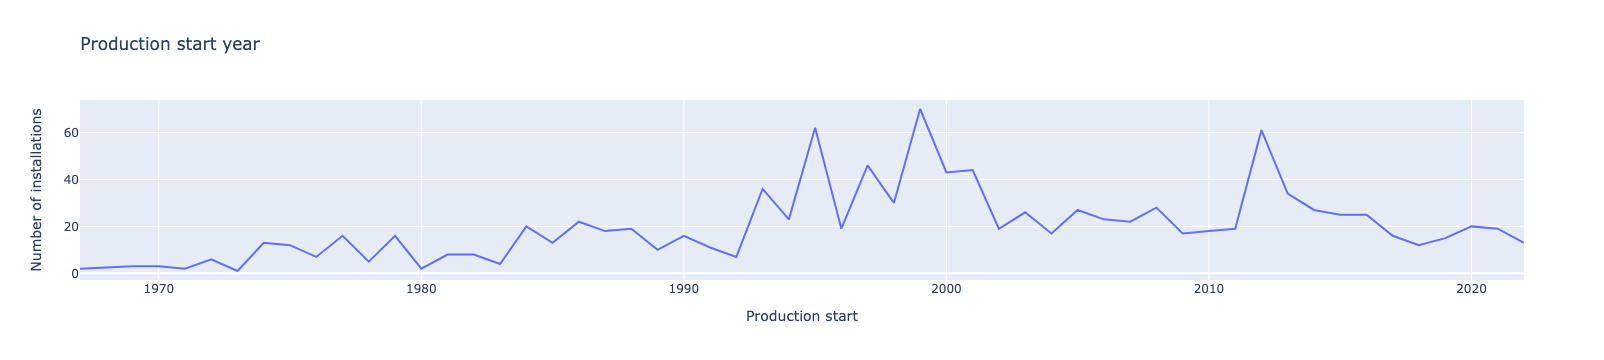

In [14]:
# Visualise in line graphs

fig = px.line(emod_date_total[emod_date_total.year < 2023], 
             x='year', 
             y='count', 
             labels = {'year': 'Production start',
                       'count': 'Number of installations'},
             title='Production start year')

fig.show()

There seem to be two peaks for when production started: around the mid ninetees to the early naughts and a a peak around 2012. Let's break it down a bit more into categories of offshore infrastructure.


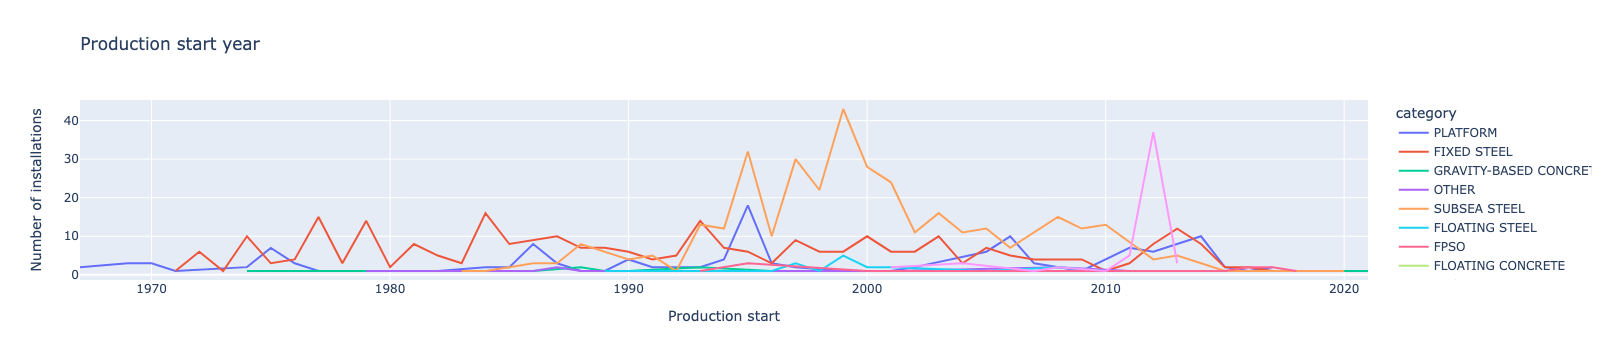

In [15]:
emod_date_category = emod_date.groupby(['year', 'category'])['id'].count().reset_index(name='count')

fig = px.line(emod_date_category[emod_date_category.year < 2023], 
             x='year', 
             y='count', 
             labels = {'year': 'Production start',
                       'count': 'Number of installations'},
             color='category',
             title='Production start year')

fig.show()

The first peak seems to be caused by an increase in fixed steel structures. These structures could be platforms because only the UK uses the term platforms as a category in the emodnet database. But fixed steel structures could be other structures as well. This needs further research. It would be interesting to find out what these structures are and what causes these peaks. The second peak, in the mid '10s is largely caused by buoys. Also the question here is: why? 

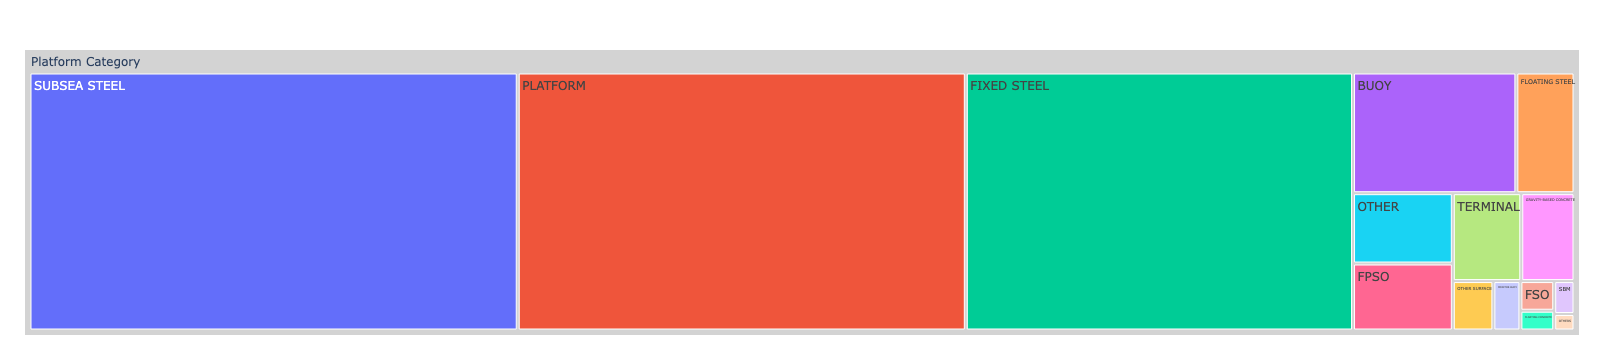

In [16]:
# Check out categories

category = emod.groupby('category')['id'].count().reset_index(name='count')

fig = px.treemap(category, path=[px.Constant("Platform Category"), 'category'], values='count')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

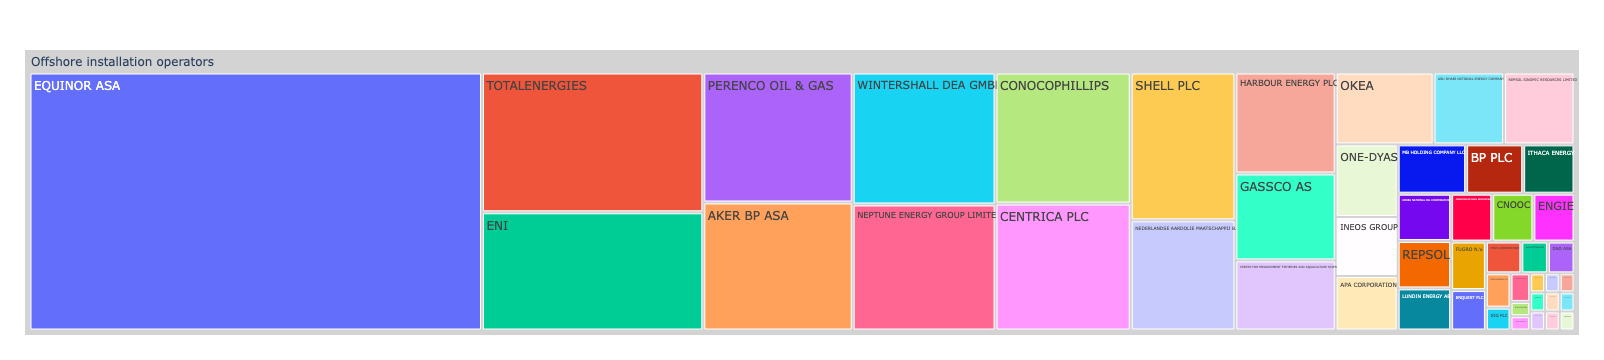

In [17]:
# Visualise involved operators

# Set query for current status: comment out what you don't want what you don't want
q = ['Decommissioned',
     'Closed down',
     'Under construction',
     'Operational'
    ]

operator = emod[emod.current_status.isin(q)].groupby('name_normalised')['id'].count().reset_index(name='count')

fig = px.treemap(operator, path=[px.Constant("Offshore installation operators"), 'name_normalised'], values='count')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

**First impressions**
1. The data from EMODnet is messier than I thought. It's hard to distinguish between different kinds of infrastructure because different categories are used for the same thing (e.g. Fixed Steel and Platforms). 
2. We know a bit more about the companies involved. Basically the ones you would expect: Equinor, Totalenergies, ENI. Perenco is interesting, and so are the Chinese owned companies (REPSOL SINOPEC and CNOOC). WINTERSHALL DEA is partly owned by Russia. 
3. For a more thorough understanding of what is out there, we need to delve into the national datasets. 

## Explore UK data

In [18]:
# Concatenate uk data

uk_points = pd.concat([uk_subsea_points, 
                       uk_subsea_points_removed, 
                       uk_surface_points, 
                       uk_surface_points_removed
                      ])

print(f'Merged dataframe has {len(uk_points)} rows')

Merged dataframe has 47781 rows


In [19]:
# The dates are in different formats, so clean that up

def convert_dates(x):
    try:
        if len(str(x)) > 8:
            date = dt.datetime.fromtimestamp(x / 1000)
        else:
            date = dt.datetime.strptime(x, '%Y%m%d')
        return date
    except:
        return pd.NaT

for col in uk_points.columns:
    if '_date' in col:
        uk_points[col + '_normalised'] = uk_points[col].apply(lambda x: convert_dates(x))


In [20]:
# Normalise names

uk_infra = pd.merge(uk_points, 
                     com[['name_db', 'name_international']],
                     left_on = 'rep_group',
                     right_on = 'name_db',
                     how='left')

uk_infra = uk_infra.rename(columns={'name_international': 'name_normalised'})

print(f'Found {uk_infra.name_normalised.isna().sum()} rows that could not be merged')

Found 36 rows that could not be merged


In [21]:
# Replace status names and add normalised column

status_to_replace = {'NOT IN USE': 'INACTIVE',
                     'ABANDONED': 'INACTIVE',
                     'REMOVED': 'INACTIVE',
                     'PRECOMMISSIONED': 'INACTIVE',
                     'PROPOSED': 'INACTIVE'}
                     
                     
uk_infra['status_normalised'] = uk_infra.status.map(status_to_replace).fillna(uk_infra.status)

In [22]:
# Remove duplicate entries

uk_infra_dedup = uk_infra.drop_duplicates(subset='feature_id', keep='last')
len(uk_infra_dedup)

35183

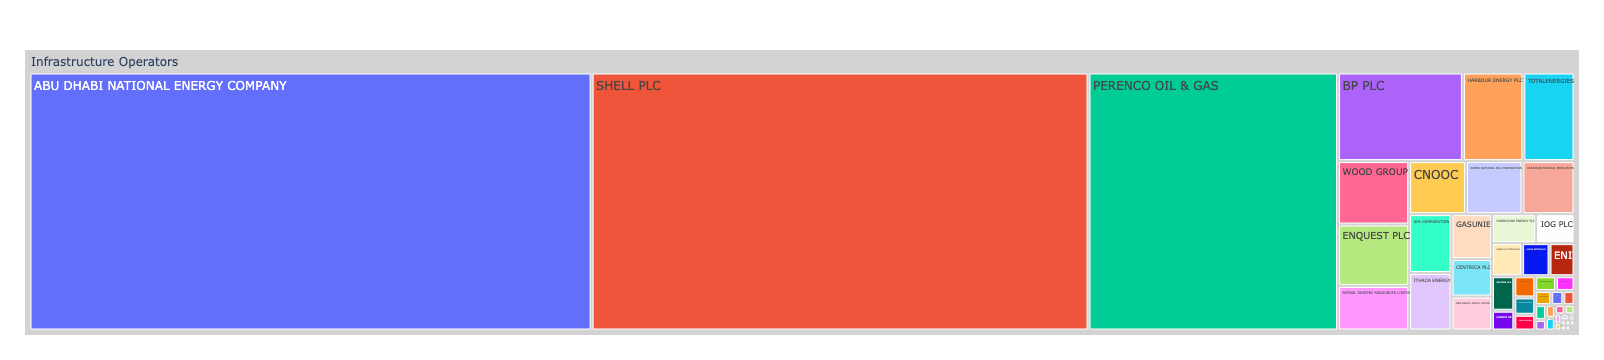

In [23]:
# Visualise infrastructure by group representative

operator = uk_infra_dedup.groupby('name_normalised')['objectid'].count().reset_index(name='count')

fig = px.treemap(operator, path=[px.Constant("Infrastructure Operators"), 'name_normalised'], values='count')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

Three companies are massively over represented. This doesn't mean that these companies own the infrastructure. They are representatives of the group, often operators or licence holders. 

Let's see the infrastructure linked to them.

In [24]:
# Filter companies

coms = ['ABU DHABI NATIONAL ENERGY COMPANY',
        'SHELL PLC',
        'PERENCO OIL & GAS']

companies = uk_infra_dedup[uk_infra_dedup['name_normalised'].isin(coms)]

print(f'Found {len(companies)} rows')

Found 29783 rows


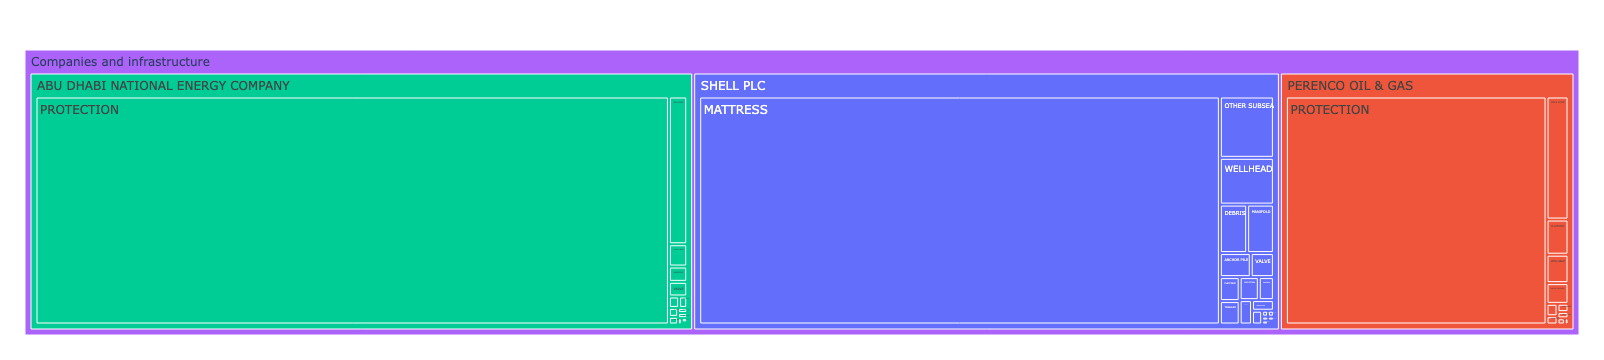

In [25]:
# Visualise assets of these companies (and drop duplicate entries)

com_infra = companies.drop_duplicates(subset='feature_id').groupby(['name_normalised', 'inf_type'])['objectid'].count().reset_index(name='count')

fig = px.treemap(com_infra, path=[px.Constant('Companies and infrastructure'), 'name_normalised', 'inf_type'], 
                 values='count',
                 color='name_normalised',
                 hover_data=['name_normalised', 'inf_type'])

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

fig.show()

```{tip}
Again, you can interact with this treemap. Just click the categories (in this case the companies) to have a closer look.
```

In [26]:
# What were the original company names in the database?

companies[['rep_group', 'name_normalised']].value_counts()

rep_group          name_normalised                  
TAQA EUROPA B.V.   ABU DHABI NATIONAL ENERGY COMPANY    12794
SHELL PLC          SHELL PLC                            11308
PERENCO OIL & GAS  PERENCO OIL & GAS                     5679
ROYAL DUTCH SHELL  SHELL PLC                                2
dtype: int64

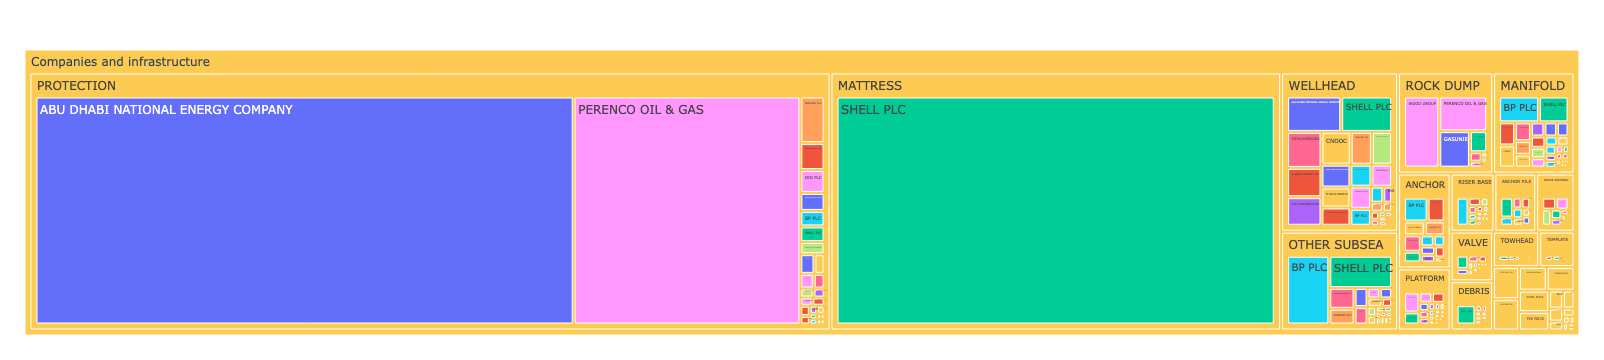

In [27]:
# Let's turn it around and take all the infrastructure as a starting point. 

uk_infra_status = uk_infra_dedup.groupby(['name_normalised', 'inf_type'])['objectid'].count().reset_index(name='count')

fig = px.treemap(uk_infra_status, path=[px.Constant('Companies and infrastructure'), 'inf_type', 'name_normalised'], 
                 values='count',
                 color='name_normalised',
                 hover_data=['name_normalised', 'inf_type'])

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

fig.show()

A quick takeaway: for large and expensive infrastructure (manifolds, platforms, riser bases, wellheads), the oil majors are dominant, which isn't very suprising. 

In [28]:
# Let's explore platforms in this dataset

uk_platforms = uk_infra[(uk_infra['inf_type'] == 'PLATFORM')].copy()

print(f'Found {len(uk_platforms)} platforms')

Found 698 platforms


The next step is a bit tricky, because we have duplicate entries, e.g. updates on existing platforms. So let's first get a sense of what is in this selection. 

In [29]:
# First look at update types

uk_platforms.upd_type.value_counts()

NO CHANGE      354
MODIFY         302
RECEIVED        20
REMOVE          12
TRANSFERRED      4
ADD              2
Name: upd_type, dtype: int64

Only two records were added. That can't mean only two platforms were built in the whole period, so there must be a cut-off date when this database was filled. Unfortunately the metadata is very sparse, so we don't know (yet) since when the update types are valid. The update dates are missing, so it's hard to check.

In [30]:
# How many unique name fields?

uk_platforms_dedup = uk_platforms.drop_duplicates(subset='name').sort_values(by='name')

print(f'Found {len(uk_platforms_dedup)} unique platforms')

Found 285 unique platforms


In [31]:
uk_platforms_dedup.status.value_counts()

ACTIVE        235
NOT IN USE     31
ABANDONED      12
REMOVED         6
PROPOSED        1
Name: status, dtype: int64

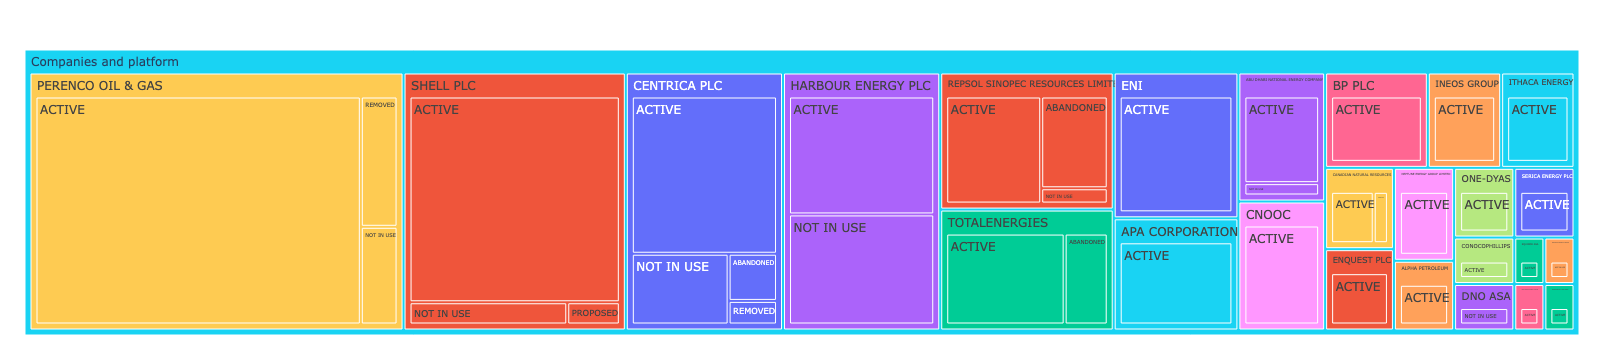

In [32]:
# Let's visualise UK platforms companies (rep group) and their status

uk_platforms_companies = uk_platforms_dedup.groupby(['name_normalised', 'status'])['objectid'].count().reset_index(name='count')

fig = px.treemap(uk_platforms_companies, path=[px.Constant('Companies and platform'), 'name_normalised', 'status'], 
                 values='count',
                 color='name_normalised',
                 hover_data=['name_normalised', 'status'])

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

fig.show()

Some observations:
1. Perenco, Shell, ENI, APA, BP, CNOOC, ITHACA, ENQUEST and TAQA (ABU DHABI, etc) have many active platforms.
2. HARBOUR ENERGY, CENTRICA, REPSOL SINOPEC, TOTAL and CONOCOPHILLIPS have relatively many platforms that are not in use or abandoned

What explains these differences?

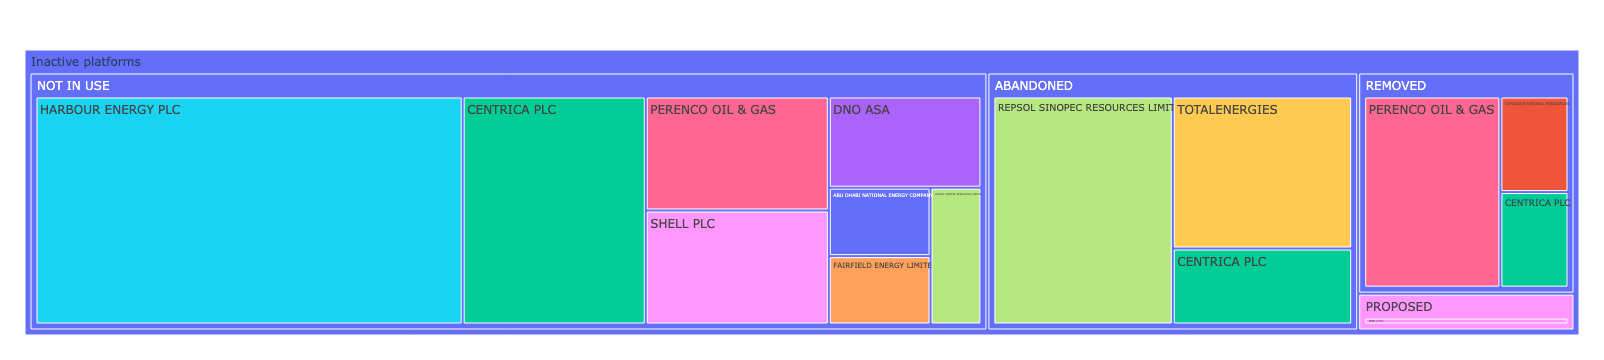

In [33]:
# Let's zoom in on assets that are not in use anymore.

uk_platforms_inactive = uk_platforms_dedup[uk_platforms_dedup['status_normalised'] == 'INACTIVE'] \
                                           .groupby(['name_normalised', 'status'])['objectid'] \
                                           .count() \
                                           .reset_index(name='count')

fig = px.treemap(uk_platforms_inactive, path=[px.Constant('Inactive platforms'), 'status', 'name_normalised'], 
                 values='count',
                 color='name_normalised',
                 hover_data=['name_normalised', 'status'])

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

fig.show()

Based on this overview I would say it would be interesting to talk to Harbour Energy (why so many platforms not in use? What has happened or is happening with these platforms? It might be nothing, but it probably takes a lot of money to decommission 14 platforms. The same goes for REPSOL SINOPEC. What does abandoning actually entail? Centrica is well represented. Perenco still has assets not in use, but has also a lot of experience with removing platforms. Shell is proposing a platform, isn't that a bit odd, since the company has been pulling back on the North Sea? What kind of platform in UK waters are we talking about? 

## Explore Netherlands infrastructure

The Dutch data is a bit sparse. The only relevant fields are name, type, operator, status and geometry. There is also well data available that might be of interest. A complicating factor is that the data also contains data on onshore facilities, which are of no interest to us.

In [34]:
# Filter items we want

infrastructure = ['Productieplatform',
                  'Subsea',
                  'Sidetap',
                  'Tanker mooring and loading system', 
                 ]

nl_infra = nl_facility[nl_facility['type'].isin(infrastructure)].copy()

print(f'Found {len(nl_infra)} relevant records')

Found 516 relevant records


In [35]:
# Merge with companies

nl_infra = pd.merge(nl_infra, 
                   com[['name_db', 'name_international',]],
                   left_on='operator', 
                   right_on='name_db', 
                   how='left')

nl_infra = nl_infra.rename(columns={'name_international': 'name_normalised'})

print(f'Found {nl_infra.name_normalised.isna().sum()} rows that could not be merged')

Found 58 rows that could not be merged


The non-mergeable are NaN's, so there is no value there in the database.

In [36]:
nl_infra['type'].value_counts()

Productieplatform                    394
Subsea                                60
Sidetap                               58
Tanker mooring and loading system      4
Name: type, dtype: int64

In [37]:
# It's all in Dutch, so translate to English

status_en = {'In gebruik': 'in use',
             'Verwijderd': 'removed',
             'Buiten gebruik gesteld': 'decommissioned or removed',
             'Niet in gebruik': 'not in use'}

type_en = {'Productieplatform': 'platform'}

nl_infra['status_en'] = nl_infra.status.map(status_en).fillna(nl_infra.status)
nl_infra['type_en'] = nl_infra['type'].map(type_en).fillna(nl_infra['type'])

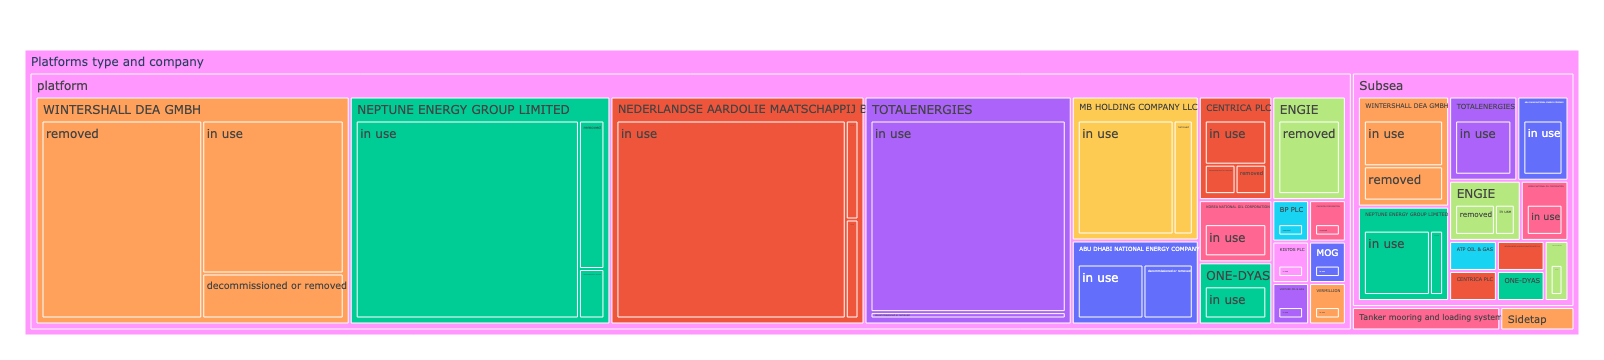

In [38]:
# Let's plot it to type and company

nl_infra_companies = nl_infra \
                    .groupby(['name_normalised', 'type_en', 'status_en'])['facility_d'] \
                    .count() \
                    .reset_index(name='count')

fig = px.treemap(nl_infra_companies, path=[px.Constant('Platforms type and company'), 'type_en', 'name_normalised', 'status_en'], 
                 values='count',
                 color='name_normalised',
                 hover_data=['name_normalised', 'type_en'])

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

fig.show()

The picture is pretty clear. Wintershall is a big player as operator of the most platforms and subsea structures, but most of the platforms are out of use. In terms of platforms out of use, Wintershall is really an outlier. How come? The NAM is important of course, but even though the NAM has been very active in the North Sea for decades, most of the currently operated plants are still in use. What explains the differences with Wintershall? Might it be that Wintershall doesn't own the platforms it operates? Neptune energy is big and Total is basically the only oil major still holding on to many platforms in the Dutch North Sea. 

## Explore NO facilities

In [39]:
# Merge Norwegian dataset with companies

no_facility.fclcurrentoperatorname = no_facility.fclcurrentoperatorname.str.upper()

no_infra = pd.merge(no_facility, 
                    com,
                    left_on='fclcurrentoperatorname',
                    right_on='name_db',
                    how='left')

no_infra = no_infra.rename(columns={'name_international': 'name_normalised'})

print(f'Found {no_infra.name_normalised.isna().sum()} rows that could not be merged')

Found 342 rows that could not be merged


About a third of rows could not be merged with the company dataset. That is because the names in the Norwegian dataset are missing. There is no known operator. In some cases the owner is known. So we have to make a choice if we want to use operators or owners. Until now we have focussed on operators, but we can change that, although this information is not always available in the other datasets. In the UK-set we use rep-groups, which might be a mix of operators and sub-contractors and licence holders.

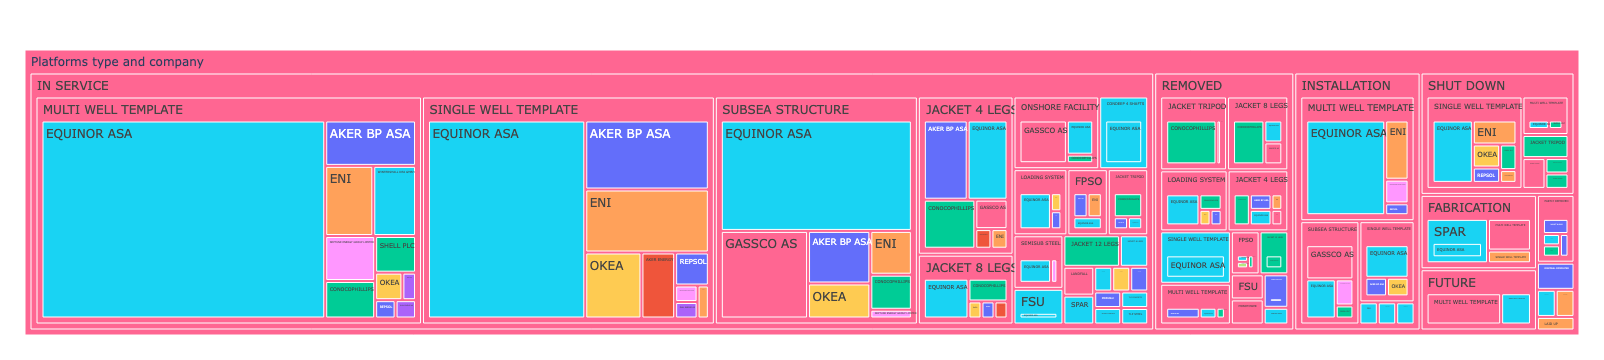

In [40]:
# Let's visualise status - type - company

no_infra_companies = no_infra \
                    .groupby(['name_normalised', 
                              'fclphase', 
                              'fclkind'])['fclnpdidfacility'] \
                    .count() \
                    .reset_index(name='count')

fig = px.treemap(no_infra_companies, path=[px.Constant('Platforms type and company'), 
                                           'fclphase', 
                                           'fclkind', 
                                           'name_normalised'], 
                 values='count',
                 color='name_normalised',
                 labels={'fclkind': 'type',
                         'name_normalised': 'company',
                         'fclphase': 'status'},
                 hover_data=['name_normalised', 'fclkind'])

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

fig.show()

There are no clear names for platforms, so... how to proceed?

I propose two approaches.

The first is to merge all national infrastructure files, as presented here, and clean them up (all with the same values for status, type and companies). It's important though to realise that you cannot do any statistics with this, because the different datasets represents different things. The UK one is most detailed, followed by the Norwegian, followed by the Netherlands. And important: this is a personal call how to rename certain status and types of infrastructure. This can easily be changed and I will add the original to the dataset, but so you know.

In [41]:
# Select and clean up uk columns

uk = uk_infra[['feature_id', 
               'name', 
               'inf_type', 
               'rep_group', 
               'descriptio', 
               'status', 
               'comments',
               'geometry',
               'name_normalised']].copy()

uk = uk.rename(columns={'inf_type': 'type',
                        'descriptio': 'description',
                        'rep_group': 'operator', #It's not entirely sure if rep_group is an operator
                        'comments': 'remarks'
                       })

uk['source_country'] = 'UK'

# Set right coordinate reference system

uk.to_crs(epsg=25831, inplace=True)

In [42]:
# Select and clean up nl columns

nl = nl_infra[['facility_d',
               'facility_n',
               'facility_c',
               'operator',
               'status_en',
               'geometry', 
               'name_normalised',
               'type_en']].copy()

nl = nl.rename(columns={'facility_d': 'feature_id',
                        'facility_n': 'name',
                        'status_en': 'status',
                        'type_en': 'type',
                        'facility_c': 'remarks' #this code is unique for NL so I put in in remarks.
                       })

nl['source_country'] = 'NL'

# Set right coordinate reference system

nl.to_crs(epsg=25831, inplace=True)

In [43]:
# Select and clean up no columns

no = no_infra[['fclnpdidfacility',
               'fclname',
               'fclkind',
               'fclphase',
               'fclcurrentoperatorname',
               'fclcurrentrespcompanyname',
               'name_normalised',
               'geometry']].copy()

no = no.rename(columns={'fclnpdidfacility': 'feature_id',
                        'fclname': 'name',
                        'fclkind': 'type',
                        'fclphase': 'status',
                        'fclcurrentoperatorname': 'operator',
                        'fclcurrentrespcompanyname': 'remarks' # this field is unique for NO, so I put it in remarks
                        })

no['source_country'] = 'NO'

# Set right coordinate reference system

no.to_crs(epsg=25831, inplace=True)

In [44]:
# Merge national infrastructure datasets

infra = pd.concat([uk, nl, no])
len(infra)

50040

In [45]:
# Clean status up

infra.status = infra.status.str.upper()

status_normalised = {'SHUT DOWN': 'NOT IN USE', #With NOT IN USE we don't know if it's been removed.
                     'IN SERVICE': 'ACTIVE',
                     'INSTALLATION': 'UNKNOWN',
                     'PRECOMMISSIONED': 'PLANNED', #It's a broad term, but with planned, the platforms aren't built yet
                     'DECOMMISSIONED OR REMOVED': 'REMOVED',
                     'DECOMMISSIONED': 'REMOVED',
                     'FUTURE': 'PLANNED',
                     'FABRICATION': 'PLANNED',
                     'PROPOSED': 'INACTIVE',
                     'DISPOSAL COMPLETED': 'REMOVED',
                     'ABANDONED IN PLACE': 'NOT IN USE',
                     'LAID UP': 'REMOVED',
                     'IN USE': 'ACTIVE'}

infra['status_normalised'] = infra.status.map(status_normalised).fillna(infra.status)

infra.status_normalised.value_counts()

ACTIVE            46873
NOT IN USE         2045
REMOVED             430
ABANDONED           423
PLANNED             100
UNKNOWN              71
INACTIVE             13
PARTLY REMOVED        6
Name: status_normalised, dtype: int64

In [46]:
# It's a bit much to rename / recategorized all infrastructure types. I will first do the platforms
# If needed I can do other categories.

infra['type'] = infra['type'].str.upper()

types_normalised = {'SEMISUB STEEL': 'PLATFORM',
                    'JACKET 4 LEGS': 'PLATFORM',
                    'JACK-UP 3 LEGS': 'PLATFORM',
                    'JACKET 8 LEGS': 'PLATFORM',
                    'JACKET TRIPOD': 'PLATFORM',
                    'SPAR': 'PLATFORM',
                    'JACKET 12 LEGS': 'PLATFORM',
                    'CONDEEP 4 SHAFTS': 'PLATFORM',
                    'JACKET 6 LEGS': 'PLATFORM',
                    'JACK-UP 4 LEGS': 'PLATFORM',
                    'CONDEEP 3 SHAFTS': 'PLATFORM',
                    'CONDEEP MONOSHAFT': 'PLATFORM'}

infra['type_normalised'] = infra['type'].map(types_normalised).fillna(infra['type'])

In [47]:
# There are some invalid geometries, let's filter them out

infra = infra[infra.geometry.is_valid].copy().reset_index()
len(infra)

49734

In [ ]:
# Write the dataframes to the database

infra.to_postgis('int_infra', 
             connection, 
             schema='dt', 
             if_exists='replace',
             index=True
                )

The second approach is we make life easier for ourselves and use the EMODnet data and clean that up a bit. For instance reclassify the infrastructure types and status, althoug that might require some manual labour. 

**Proposal emodnet data reclassification**

|Category|Reclassification|
|--------|----------------|
|SUBSEA STEEL|PLATFORM|
|PLATFORM|PLATFORM|
|FIXED STEEL|PLATFORM|
|BUOY|exclude from selection|
|OTHER|exclude from selection|
|FLOATING STEEL|PLATFORM|
|FPSO|exclude from selection|
|TERMINAL|PLATFORM|
|GRAVITY-BASED CONCRETE|PLATFORM|
|OTHER SURFACE|exclude from selection|
|MONITOR BUOY|exclude from selection|
|FSO|exclude from selection|
|SBM|exclude from selection|
|OTHERS|exclude from selection|

In [49]:
# Let's get a sample of what FIXED STEEL items we need. 

emod[['category', 'remarks']] \
[emod['category'] \
 .isin(['FIXED STEEL', 'FLOATING STEEL', 'TERMINAL', 'GRAVITY-BASED CONCRETE']) & \
 (emod['remarks'].str.contains('Wellh|Fla|templa', regex=True, case=False) == False)]\
.drop_duplicates()[10:30]

category                                            remarks
55   FIXED STEEL                                  s./p. = 3500/2600
64   FIXED STEEL                                               P.I.
70   FIXED STEEL                      Production stopped 01-01-2016
72   FIXED STEEL  New production platform installed (Source: Sod...
74   FIXED STEEL                                    Re-used as P6-D
75   FIXED STEEL  Re-use of re-furbished K11-B installation inst...
76   FIXED STEEL  Re-use of adjusted K12-E installation installe...
81   FIXED STEEL  Topside removed in 2005 (Source SodM 2005, p. ...
85   FIXED STEEL      P.I. (production, compression, accommodation)
89   FIXED STEEL                                       Former P2-SE
90   FIXED STEEL  P.I. (production, compression, accommodation),...
93   FIXED STEEL  Platform removed in 2005 (Source: SodM 2005, p...
97   FIXED STEEL                                P.I. bridge C-P 105
101  FIXED STEEL                                             Reused
102  FIXED STEEL                                        Compression
104  FIXED STEEL  Gastreatment platform + compression installed ...
110  FIXED STEEL       Bridge Q-C 83, bridge Q-P 112,bridge P-PK 15
111  FIXED STEEL                         Compression, accommodation
113  FIXED STEEL                                            Removed
123  FIXED STEEL                                          Monotower

I think it's not possible or desirable to extract all platforms. The data is just too messy, so we need to find another way. The data can be used though, but let's then just use all EMODnet data. 

In [ ]:
# Write it to postgresql

emod.to_postgis('int_infra_emodnet', 
             connection, 
             schema='dt', 
             if_exists='replace',
             index=True
                )